In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import numpy as np
from utils import OUR_NAME

from sky_spot import env
from plot import * 
sns.set_style('whitegrid')
InitMatplotlib(7, 7)

colors = sns.color_palette('colorblind')

complete_str = ''
# complete_str = '_complete'

# ENV_PATH = '../../exp-for-plot/real{complete_str}/real{complete_str}/us-west-2a_v100_1.json/traces/random_start/0.json'


DATE = ''
# DATE = '2023-04-22-29'
# DATE = '2023-04-19-29'
# DATE = 'gcp-2023-04-30'
if DATE == '':
    TASK_DURATION_HOURS = 48
    DDL = 60

    env_name = 'us-west-2b_k80_8' # Trace examples
    # env_name = 'us-west-2a_v100_1'
    # env_name = 'us-west-2a_k80_1'
    OVERHEAD = 0.2 # Trace examples
    # OVERHEAD = 0.0

    # INDEX = 289
    # INDEX = 100
    INDEX = 4
    INDEX = 65
    # INDEX = 91
    result = f'../../results/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}.csv'
elif DATE == '2023-04-22-29':
    TASK_DURATION_HOURS = 76
    DDL = 100
    # DDL = 84
    OVERHEAD = 0.3
    env_name = 'us-west-2b_v100_1'
    INDEX = 0
    result = f'../../results-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/{env_name}.csv'
elif DATE == '2023-04-19-29':
    TASK_DURATION_HOURS = 27
    DDL = 36
    # DDL = 30
    OVERHEAD = 0.2
    env_name = 'us-east-1c_intel_64'
    INDEX = 0
    result = f'../../results-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/{env_name}.csv'
elif DATE == 'gcp-2023-04-30':
    TASK_DURATION_HOURS = 22.5
    # DDL = 24
    DDL = 28
    # DDL = 30
    OVERHEAD = 0.16
    env_name = 'us-east1-b_c3-88'
    # env_name = 'us-east1-b_c3-176'
    # env_name = 'us-central1-b_c3-176'
    INDEX = 0
    result = f'../../results-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/{env_name}.csv'



ENV_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}.json/traces/random_start/{INDEX}.json'
with open(ENV_PATH) as f:
    env = json.load(f)
    trace = 1 - np.array(env['data'])
    trace += 1
    gap_seconds = env['metadata']['gap_seconds']

def load_exp(strategy_folder, index, my_traces, name, overhead=OVERHEAD):
    try:
        RESULTS_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={overhead:.2f}/real{complete_str}/{env_name}.json/{strategy_folder}/result.json'
        with open(RESULTS_PATH) as f:
            exp = json.load(f)['history']
            strategy_df = exp
        if index is not None:
            exp = exp[index]
            strategy_df = pd.DataFrame(exp)
        assert name not in my_traces
        my_traces[name] = strategy_df
    except Exception as e:
        print(e)

def load_trace_for_index(index, overhead=OVERHEAD):
    traces = {}
    
    ENV_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={overhead:.2f}/real{complete_str}/{env_name}.json/traces/random_start/{index}.json'
    with open(ENV_PATH) as f:
        env = json.load(f)
        trace = 1 - np.array(env['data'])
        trace += 1
        gap_seconds = env['metadata']['gap_seconds']
    env_df = pd.DataFrame({
        'Elapsed': np.arange(1, len(trace) + 1) * gap_seconds,
        'ClusterType': trace,
    }, columns=['Elapsed', 'ClusterType'])
    traces['Spot Availability'] = env_df

    load_exp(f'on_demand-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}', index, traces, 'On-Demand', overhead)
    load_exp(f'rc_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-keep_on_demand=1.0', index, traces, f'{OUR_NAME} (plain)', overhead)
    load_exp(f'rc_vd_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', index, traces, f'{OUR_NAME} (VD)', overhead)
    load_exp(f'rc_v2dt_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', index, traces, f'{OUR_NAME} (V2DT)', overhead)
    load_exp(f'rc_cr_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', index, traces, f'{OUR_NAME}', overhead)
    load_exp(f'ideal_ilp_overhead-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', index, traces, 'Omniscient', overhead)
    if 'Omniscient' not in traces:
        print('use quick Omniscient')
        load_exp(f'quick_optimal-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}', index, traces, 'Omniscient', overhead)
    load_exp(f'quick_optimal_paranoid-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}', index, traces, 'Paranoid', overhead)
    load_exp(f'ideal_ilp_overhead_sliced_by_num-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-slice=8', index, traces, 'Omniscient (sliced: 8)', overhead)

    # RESULTS_PATH = f'../../exp-for-plot/real{complete_str}/real{complete_str}/us-west-2a_v100_1.json/rc_threshold-task_duration_hours={TASK_DURATION_HOURS}.0/result.json'
    # with open(RESULTS_PATH) as f:
    #     exp = json.load(f)
    # strategy_df = pd.DataFrame.from_records(exp['history'][0])
    # traces[exp['strategy']['name']] = strategy_df

    # RESULTS_PATH = f'../../exp-for-plot/real{complete_str}/real{complete_str}/us-west-2a_v100_1.json/rc_threshold-task_duration_hours={TASK_DURATION_HOURS}.0-keep_on_demand=1.0/result.json'
    # with open(RESULTS_PATH) as f:
    #     exp = json.load(f)
    # strategy_df = pd.DataFrame.from_records(exp['history'][0])
    # traces[exp['strategy']['name']+'(keep_on_demand)'] = strategy_df


    # NUM_SLICES = 1
    # RESULTS_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL:.0f}+task={TASK_DURATION_HOURS:.0f}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}.json/loose_time_sliced_by_num-task_duration_hours={TASK_DURATION_HOURS}.0-deadline_hours={DDL:.1f}-slice={NUM_SLICES}/result.json'
    # with open(RESULTS_PATH) as f:
    #     exp = json.load(f)
    # strategy_df = pd.DataFrame.from_records(exp['history'][0])
    # traces['sliced' + f' (\#slices: {NUM_SLICES})'] = strategy_df

    load_exp(f'strawman-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', index, traces, 'Greedy', overhead)

    num_slices = 0
    try:
        result_df = pd.read_csv(result)
        result_df = result_df[(result_df['strategy'] == 'time_sliced_by_num') & (result_df['deadline_hours'] == DDL) & (result_df['task_duration_hours'] == TASK_DURATION_HOURS)]
        num_slices = int(result_df.loc[result_df['avg_cost'].idxmin(), 'num_slices'])
        print(num_slices)

        load_exp(f'time_sliced_by_num-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-slice={num_slices:.0f}', index, traces, 'Time Sliced' + f' ({num_slices})', overhead)
    except: pass

    print(list(traces.keys()))
    return traces, num_slices



use_tex True 
font_size 7 
title_size 7


In [2]:
import math

def get_slice_intervals(deadline, num_slices):
    deadline = deadline * 3600
    slice_intervals = []
    slice_interval = deadline / num_slices
    for i in range(num_slices):
        actual_slice_interval = (i + 1) * slice_interval - sum(
            slice_intervals)
        rounded_slice_interval = math.floor(
            actual_slice_interval / gap_seconds) * gap_seconds
        slice_intervals.append(rounded_slice_interval)
    slice_intervals[-1] = deadline - sum(slice_intervals[:-1])
    return [interval / 3600 for interval in slice_intervals]

In [3]:
from sky_spot import utils
for device in utils.COST_SCALES:
    if device in env_name:
        cost_scale = utils.COST_SCALES[device]
        break
else:
    print('cost scale not found. Use 1')
    cost_scale = 1
def plot_trace(fig, plot_algos, traces, num_slices=None, show_cost=True, show_spot_fraction=True):
    axes = fig.subplots(len(plot_algos), sharex=True)
    fig.subplots_adjust(hspace=-0.2)
    if len(plot_algos) == 1:
        axes = [axes]
    v100_base_cost = utils.COSTS[utils.ClusterType.ON_DEMAND]


    # axes = [fig.add_subplot(111)]
    for i, algo in enumerate(plot_algos):
        if algo not in traces:
            continue
        df = traces[algo]
        sns.lineplot(x=df['Elapsed'] / 3600,
                    y=df['ClusterType'] - 1,
                    drawstyle='steps-pre',
                    ax=axes[i])
        TITLE_Y = .8
        if algo in ['Omniscient', 'Greedy']:
            print('first on demand', df[df['ClusterType'] == 3]['Elapsed'].min())
        if algo == 'Omniscient (no overhead)':
            axes[i].set_title(
                fr'Greedy (Omniscient, Cost: \${df["Cost"].iloc[-1]:.2f})', y=TITLE_Y)
        else:
            cost_str = fr' (\${df["Cost"].iloc[-1] * cost_scale:.2f})' if 'Cost' in df and show_cost else ''
            axes[i].set_title(f'{algo.replace(f"Limited Deficit", f"{OUR_NAME} (Ours)")}{cost_str}', y=TITLE_Y)
        axes[i].set_ylabel('')
        axes[i].set_xlim(0, DDL)
        axes[i].set_yticks([0, 1, 2])
        axes[i].set_yticklabels(['IDLE', 'SPOT', 'VM'])
        axes[i].legend().set_visible(False)
        axes[i].set_ylim(-.06, 2.06)
        if 'Spot Availability' in algo:
            print(df['ClusterType'].value_counts())
            spot_fraction = sum(df['ClusterType'] == 2) / len(df)
            title = algo
            if show_spot_fraction:
                title += f' (Spot Fraction: {spot_fraction:.2f})'
            axes[i].set_title(title, y=TITLE_Y)
        if 'Time Sliced' in algo:
            slice_intervals = get_slice_intervals(DDL, num_slices)
            bounds = np.cumsum(slice_intervals) - gap_seconds / 3600 - 0.18
            bounds = bounds.tolist()
            bounds.insert(0, 0)
            colors = ['grey', 'green']
            for j in range(len(bounds) - 1):
                axes[i].fill_between([bounds[j], bounds[j+1]], [2, 2], color=colors[j%2], alpha=0.15)
            # axes[i].vlines(bounds,
            #                -0.1,
            #                2.4,
            #                color='black',
            #                alpha=0.8,
            #                linewidth=0.8,
            #                linestyles='--')

    axes[-1].set_xlabel('Elapsed Time (hours)', labelpad=2)
    # fig.suptitle(f'Cluster Type Over Time {env_name}\n(Task Fraction: {TASK_DURATION_HOURS}/{DDL}, only VM cost: \${v100_base_cost * cost_scale * (TASK_DURATION_HOURS + OVERHEAD):.2f})')



7
['Spot Availability', 'On-Demand', 'Uniform Progress (plain)', 'Uniform Progress (VD)', 'Uniform Progress (V2DT)', 'Uniform Progress', 'Omniscient', 'Paranoid', 'Omniscient (sliced: 8)', 'Greedy', 'Time Sliced (7)']


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


2    245
1    117
Name: ClusterType, dtype: int64
first on demand 53400


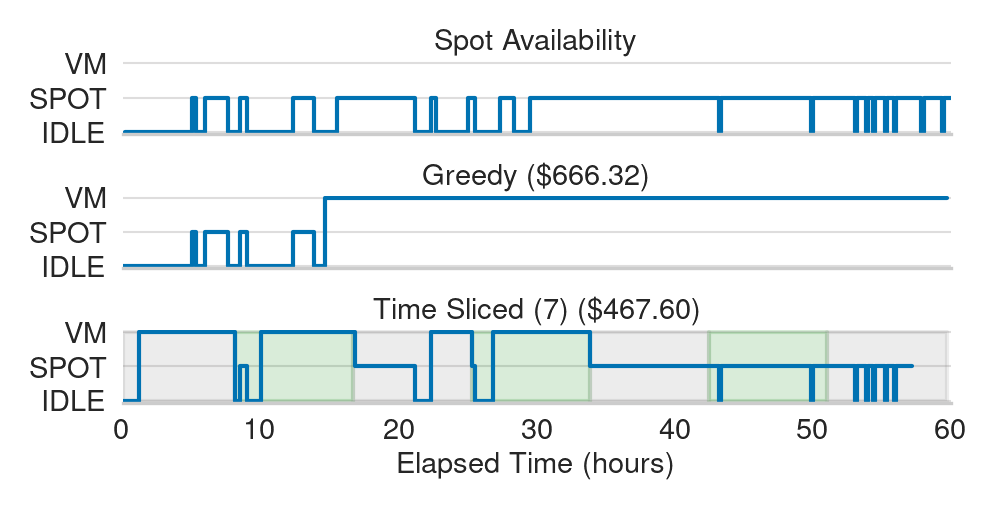

In [4]:
if DATE == '':
    traces, num_slices = load_trace_for_index(INDEX)
    PLOT_ALGOS = list(traces.keys())
    # PLOT_ALGOS = ['only spot', 'greedy', f'sliced (\#slices: {NUM_SLICES})', '{OUR_NAME} (V2DT)', 'Omniscient']
    PLOT_ALGOS = [
        'Spot Availability',
        'Greedy',
        f'Time Sliced ({num_slices})',
        #   '{OUR_NAME}',
        #   'Omniscient',
    ]
    fig = plt.figure(figsize=(fig_width, fig_height - .4), dpi=300)
    plot_trace(fig, PLOT_ALGOS, traces, num_slices, show_spot_fraction=False)
    fig.tight_layout()
    fig.savefig('figures/example_trace.pdf', bbox_inches='tight', pad_inches=0)

7
['Spot Availability', 'On-Demand', 'Uniform Progress (plain)', 'Uniform Progress (VD)', 'Uniform Progress (V2DT)', 'Uniform Progress', 'Omniscient', 'Paranoid', 'Omniscient (sliced: 8)', 'Greedy', 'Time Sliced (7)']


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


2    242
1    120
Name: ClusterType, dtype: int64
first on demand 98400


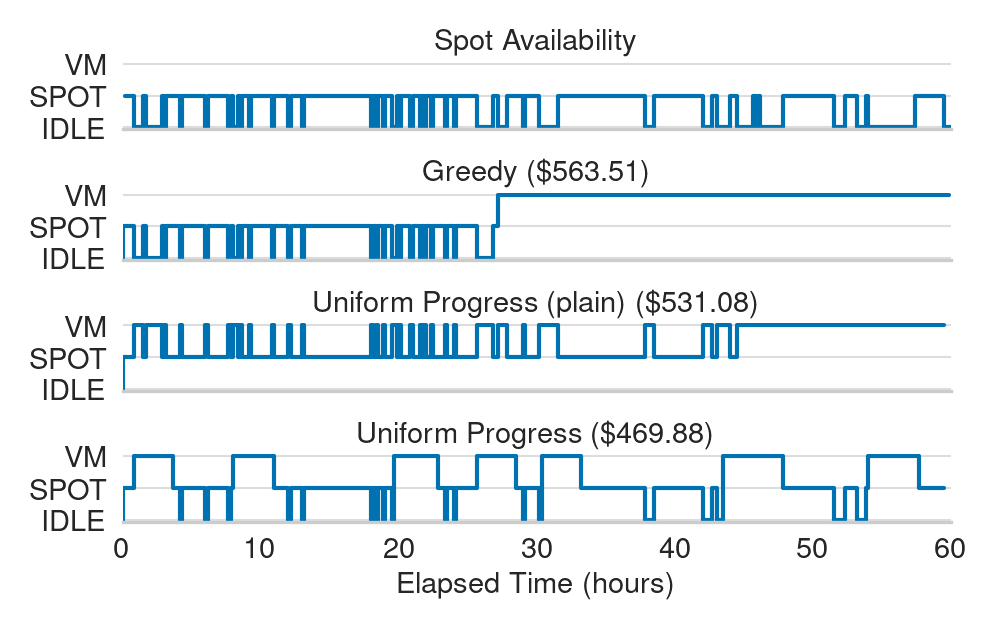

In [5]:
if DATE == '':
    traces, num_slices = load_trace_for_index(39)
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    plot_trace(fig, ['Spot Availability', 'Greedy', f'{OUR_NAME} (plain)', f'{OUR_NAME}'], traces, num_slices, show_spot_fraction=False)
    fig.tight_layout()
    fig.savefig('figures/ld_compare.pdf', bbox_inches='tight', pad_inches=0)

In [6]:
if DATE == '2023-04-22-29':
    if DDL == 100:
        traces, num_slices = load_trace_for_index(7)

        # fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        plot_trace(fig, [
            'Spot Availability',
            'On-Demand',
            'Greedy',
            f'{OUR_NAME}',
            'Omniscient'
        ], traces, num_slices, show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/ml_workload_trace.pdf', bbox_inches='tight')
    if DDL == 84:
        # traces, num_slices = load_trace_for_index(1)
        traces, num_slices = load_trace_for_index(7)

        fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        plot_trace(fig, [
            'Spot Availability',
            'On-Demand',
            'Greedy',
            f'{OUR_NAME}',
            'Omniscient'
        ], traces, num_slices, show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/ml_workload_trace_ddl84.pdf', bbox_inches='tight')

[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/rc_threshold-task_duration_hours=48.0-deadline_hours=60.0-keep_on_demand=1.0/result.json'
[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/rc_vd_threshold-task_duration_hours=48.0-deadline_hours=60.0/result.json'
[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/rc_v2dt_threshold-task_duration_hours=48.0-deadline_hours=60.0/result.json'
[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/rc_cr_threshold-task_duration_hours=48.0-deadline_hours=60.0/result.json'
[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/ideal_ilp_overhead-task_duration_hours=48.0-deadline_hours=60.0/result.json'
use quick Omni

No handles with labels found to put in legend.
No handles with labels found to put in legend.


7
[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.00/real/us-west-2b_k80_8.json/time_sliced_by_num-task_duration_hours=48.0-deadline_hours=60.0-slice=7/result.json'
['Spot Availability', 'On-Demand', 'Greedy']
2    329
1    225
Name: ClusterType, dtype: int64
7
['Spot Availability', 'On-Demand', 'Uniform Progress (plain)', 'Uniform Progress (VD)', 'Uniform Progress (V2DT)', 'Uniform Progress', 'Omniscient', 'Paranoid', 'Omniscient (sliced: 8)', 'Greedy', 'Time Sliced (7)']


No handles with labels found to put in legend.


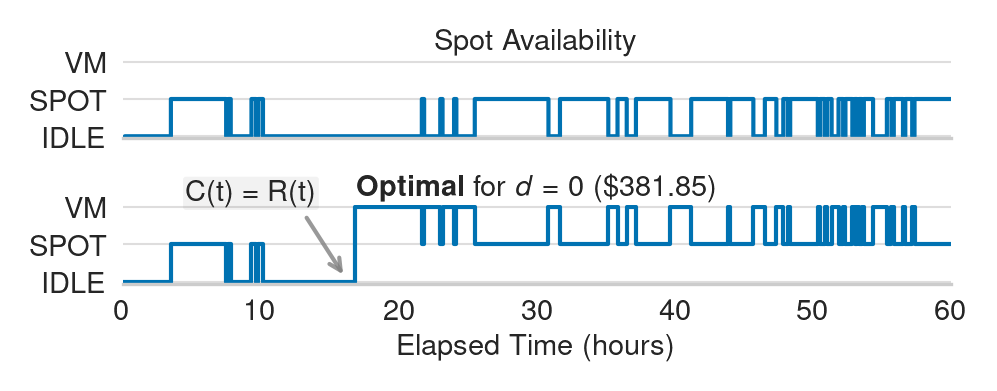

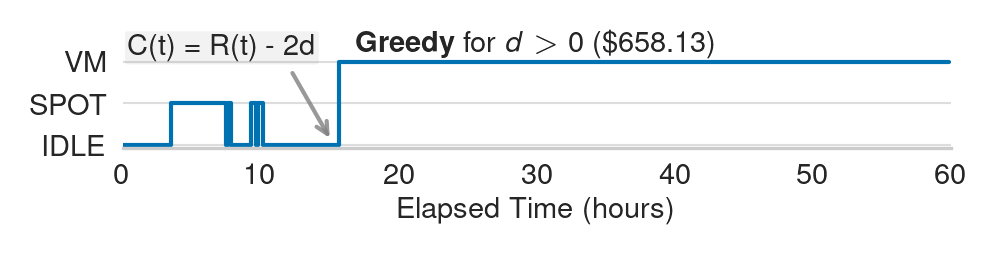

In [7]:
if DATE == '':
    traces, num_slices = load_trace_for_index(1, overhead=0.0)
    traces['\\textbf{Optimal} for $d=0$'] = traces['Greedy']
    fig = plt.figure(figsize=(fig_width, fig_height - .8), dpi=300)
    plot_trace(fig, ['Spot Availability', '\\textbf{Optimal} for $d=0$'], traces, num_slices, show_cost=True, show_spot_fraction=False)

    ax = fig.get_axes()[1]
    ax.text(14,
            2.0,
            'C(t) = R(t)',
            va='bottom',
            ha='right',
            bbox=dict(facecolor='gray',
                      alpha=0.1,
                      edgecolor='none',
                      boxstyle='round,pad=0.1'))
    ax.annotate('', xy=(16.3, 0), xytext=(13, 1.9), arrowprops=dict(arrowstyle='->', color='gray', alpha=0.8))

    fig.tight_layout()
    fig.savefig('figures/trace_overhead_0.pdf', bbox_inches='tight', pad_inches=0)

    with_overhead_traces, _ = load_trace_for_index(1, overhead=0.2)
    # with_overhead_traces['Omniscient'] = with_overhead_traces['Omniscient']
    with_overhead_traces['\\textbf{Greedy} for $d>0$'] = with_overhead_traces['Greedy']
    fig = plt.figure(figsize=(fig_width, fig_height - 1.225), dpi=300)
    plot_trace(fig,
            [
                # 'Omniscient',
                '\\textbf{Greedy} for $d>0$',
                ],
            with_overhead_traces,
            num_slices,
            show_cost=True)
    ax = fig.get_axes()[0]
    ax.text(14,
            2.0,
            'C(t) = R(t) - 2d',
            va='bottom',
            ha='right',
            bbox=dict(facecolor='gray',
                      alpha=0.1,
                      edgecolor='none',
                      boxstyle='round,pad=0.1'))
    ax.annotate('', xy=(15.3, 0), xytext=(12, 1.9), arrowprops=dict(arrowstyle='->', color='gray', alpha=0.8))
    fig.tight_layout()
    fig.savefig('figures/trace_overhead_1.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
if DATE == '2023-04-19-29':
    if DDL == 36:
        traces, num_slices = load_trace_for_index(15)

        # fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        fig = plt.figure(figsize=(fig_width, fig_height + .8), dpi=300)
        plot_trace(fig, [
            'Spot Availability', 'On-Demand', 'Greedy', f'{OUR_NAME}',
            'Omniscient'
        ],
                traces,
                num_slices,
                show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/spark_workload_trace.pdf', bbox_inches='tight')
    if DDL == 30:
        traces, num_slices = load_trace_for_index(7)

        # fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        fig = plt.figure(figsize=(fig_width, fig_height + .8), dpi=300)
        plot_trace(fig, [
            'Spot Availability', 'On-Demand', 'Greedy', f'{OUR_NAME}',
            'Omniscient'
        ],
                traces,
                num_slices,
                show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/spark_workload_trace.pdf', bbox_inches='tight')

In [9]:
if DATE == 'gcp-2023-04-30':
    if DDL == 24:
        traces, num_slices = load_trace_for_index(11)

        # fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        fig = plt.figure(figsize=(fig_width, fig_height + .8), dpi=300)
        plot_trace(fig, [
            'Spot Availability',
            'On-Demand',
            'Greedy',
            f'{OUR_NAME}',
            'Omniscient'
        ], traces, num_slices, show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/spark_workload_trace.pdf', bbox_inches='tight')
    if DDL == 28:
        traces, num_slices = load_trace_for_index(1)

        # fig = plt.figure(figsize=(fig_width, fig_height - .6), dpi=300)
        fig = plt.figure(figsize=(fig_width, fig_height + .8), dpi=300)
        plot_trace(fig, [
            'Spot Availability',
            'On-Demand',
            'Greedy',
            f'{OUR_NAME}',
            'Omniscient'
        ], traces, num_slices, show_cost=True)
        fig.tight_layout()
        fig.savefig('figures/spark_workload_trace.pdf', bbox_inches='tight')


In [10]:
from sky_spot.utils import ClusterType, COSTS

statistics = []

histories = {}
load_exp(f'rc_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-keep_on_demand=1.0', None, histories, f'{OUR_NAME} (plain)')
load_exp(f'rc_cr_threshold-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', None, histories, f'{OUR_NAME}')
load_exp(f'ideal_ilp_overhead-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', None, histories, 'Omniscient')
if 'Omniscient' not in histories:
    print('using quick Omniscient')
    load_exp(
        f'quick_optimal-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}',
        None, histories, 'Omniscient')
load_exp(f'strawman-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}', None, histories, 'Greedy')
load_exp(f'time_sliced-task_duration_hours={TASK_DURATION_HOURS:.1f}-deadline_hours={DDL:.1f}-slice={num_slices}', None, histories, f'Time Sliced ({num_slices})')
load_exp(f'on_demand-deadline_hours={DDL:.1f}-task_duration_hours={TASK_DURATION_HOURS:.1f}', None, histories, 'On-Demand')

print(list(histories.keys()))


for filename in os.listdir(f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}.json/traces/random_start'):
    if not filename.endswith('.json'):
        continue
    index = int(filename.split('.')[0])

    new_traces = {}
    ENV_PATH = f'../../exp-for-plot/real{complete_str}/{DATE}/ddl={DDL}+task={TASK_DURATION_HOURS}+overhead={OVERHEAD:.2f}/real{complete_str}/{env_name}.json/traces/random_start/{index}.json'
    with open(ENV_PATH) as f:
        env = json.load(f)
        trace = 1 - np.array(env['data'])
        gap_seconds = env['metadata']['gap_seconds']
    env_df = pd.DataFrame({
        'Elapsed': np.arange(len(trace)) * gap_seconds,
        'ClusterType': trace + 1,
    }, columns=['Elapsed', 'ClusterType'])
    new_traces['only spot'] = env_df

    for strategy in histories:
        strategy_df = pd.DataFrame.from_records(histories[strategy][index])
        new_traces[strategy] = strategy_df
    # strategy_df = pd.DataFrame.from_records(histories[f'{OUR_NAME}'][index])
    # new_traces[f'{OUR_NAME}'] = strategy_df


    # strategy_df = pd.DataFrame.from_records(histories[f'{OUR_NAME} (plain)'][index])
    # new_traces[f'{OUR_NAME} (plain)'] = strategy_df

    # strategy_df = pd.DataFrame.from_records(histories['Greedy'][index])
    # new_traces['Greedy'] = strategy_df

    # strategy_df = pd.DataFrame.from_records(histories[f'Time Sliced ({num_slices})'][index])
    # new_traces[f'Time Sliced ({num_slices})'] = strategy_df

    # if 'Omniscient' in histories:
    #     strategy_df = pd.DataFrame.from_records(histories['Omniscient'][index])
    #     new_traces['Omniscient'] = strategy_df

    for i, algo in enumerate(new_traces.keys()):
        df = new_traces[algo]

        history = df['ClusterType'].to_numpy()
        history = np.array([0] + history.tolist() + [0])
        switch_to_spot = sum((history[1:] == ClusterType.SPOT.value) & (history[:-1] != ClusterType.SPOT.value))
        switch_to_vm = sum((history[1:] == ClusterType.ON_DEMAND.value) & (history[:-1] != ClusterType.ON_DEMAND.value))
        idle_time = sum(history[1:-1] == ClusterType.NONE.value)
        vm_time = sum(history[1:-1] == ClusterType.ON_DEMAND.value)
        spot_time = sum(history[1:-1] == ClusterType.SPOT.value)
        statistics.append(dict(
            index=index,
            strategy=algo,
            switch_to_spot=switch_to_spot,
            switch_to_vm=switch_to_vm,
            idle_time=idle_time,
            vm_time=vm_time,
            spot_time=spot_time,
            cost=df['Cost'].max() if 'Cost' in df else 0,
        ))

statistics_df = pd.DataFrame.from_records(statistics, columns=['index', 'strategy', 'switch_to_spot', 'switch_to_vm', 'idle_time', 'vm_time', 'spot_time', 'cost'])
statistics_df


[Errno 2] No such file or directory: '../../exp-for-plot/real//ddl=60+task=48+overhead=0.20/real/us-west-2b_k80_8.json/time_sliced-task_duration_hours=48.0-deadline_hours=60.0-slice=7/result.json'
['Uniform Progress (plain)', 'Uniform Progress', 'Omniscient', 'Greedy', 'On-Demand']


,index,strategy,switch_to_spot,switch_to_vm,idle_time,vm_time,spot_time,cost
0,73,only spot,13,0,240,0,122,0.000000
1,73,Uniform Progress (plain),12,8,48,194,118,118.077633
2,73,Uniform Progress,10,6,53,222,85,127.005583
3,73,Omniscient,8,2,61,186,114,113.348900
4,73,Greedy,3,1,67,260,33,137.952050
...,...,...,...,...,...,...,...,...
1795,185,Uniform Progress (plain),29,29,7,171,182,116.727367
1796,185,Uniform Progress,23,9,31,187,138,117.751300
1797,185,Omniscient,27,8,31,92,238,85.519633
1798,185,Greedy,18,1,49,209,102,123.132700


In [11]:
costs_gap = []
demand_cost_gap = []
spot_fractions = []
for index, group in statistics_df.groupby('index'):
    greedy_ld_gap = (
        group[group['strategy'] == f'Greedy']['cost'].iloc[0] -
        group[group['strategy'] == f'{OUR_NAME}']['cost'].iloc[0]
    ) / group[group['strategy'] == f'Greedy']['cost'].iloc[0]
    demand_ld_gap = (
        group[group['strategy'] == f'On-Demand']['cost'].iloc[0] -
        group[group['strategy'] == f'{OUR_NAME}']['cost'].iloc[0]
    ) / group[group['strategy'] == f'On-Demand']['cost'].iloc[0]
    spot_fraction = group[group['strategy'] == 'only spot']['spot_time'].iloc[0]
    spot_fractions.append((index, spot_fraction))
    costs_gap.append((index, greedy_ld_gap))
    demand_cost_gap.append((index, demand_ld_gap))

print(sorted(costs_gap, key=lambda x: x[1], reverse=True))
print(sorted(demand_cost_gap, key=lambda x: x[1], reverse=True))
print(sorted(spot_fractions, key=lambda x: x[1], reverse=False))

[(298, 0.3894312852398654), (59, 0.3875444886525459), (113, 0.3867678366368003), (7, 0.3849130603527571), (264, 0.3796502037531793), (278, 0.372594888707516), (50, 0.3689931086905394), (164, 0.3673381010091922), (65, 0.35391035582889485), (214, 0.35391035582889485), (281, 0.3461444809250766), (259, 0.3415626689661175), (108, 0.3414004269030348), (92, 0.33802614641275863), (82, 0.3353987845932835), (153, 0.32102699802484674), (110, 0.3179054485435495), (163, 0.3142727340015323), (97, 0.3110522994928128), (83, 0.3079226077347168), (96, 0.3041335157649259), (104, 0.29055617234395825), (107, 0.2897315779341363), (188, 0.2440650491684992), (38, 0.24060255656623725), (291, 0.23645921785891683), (145, 0.2298164432944785), (91, 0.2228523894978893), (139, 0.20214001888376198), (13, 0.1876941376997144), (196, 0.1851881309190608), (57, 0.1817498611455584), (61, 0.18136450574121268), (227, 0.1798090408668765), (233, 0.17905972503944093), (54, 0.17804832358872094), (140, 0.17589422732408241), (191,

In [12]:
# statistics_df.groupby('index')

# costs_gap = []
# cost_gap_ld = []
# for index, group in statistics_df.groupby('index'):
#     greedy_slice_gap = group[
#         group['strategy'] == 'Greedy']['cost'].iloc[0] - group[
#             group['strategy'] == f'Time Sliced ({num_slices})']['cost'].iloc[0]
#     sliced_ld_gap = group[group['strategy'] == f'Time Sliced ({num_slices})']['cost'].iloc[0] - group[group['strategy'] == f'{OUR_NAME}']['cost'].iloc[0]
#     greedy_ld_plain_gap = group[group['strategy'] == 'Greedy']['cost'].iloc[0] - group[group['strategy'] == f'{OUR_NAME} (plain)']['cost'].iloc[0]
#     ld_plain_ld_gap = group[group['strategy'] == f'{OUR_NAME} (plain)']['cost'].iloc[0] - group[group['strategy'] == f'{OUR_NAME}']['cost'].iloc[0]
#     costs_gap.append((index, greedy_slice_gap * sliced_ld_gap**5))
#     cost_gap_ld.append((index, greedy_ld_plain_gap * ld_plain_ld_gap**3))

# print(sorted(costs_gap, key=lambda x: x[1], reverse=True))
# print(sorted(cost_gap_ld, key=lambda x: x[1], reverse=True))



In [13]:
if DATE == '':
    aggregated = statistics_df.groupby('strategy').mean()
elif DATE == '2023-04-22-29':
    aggregated = statistics_df[statistics_df['index'] == 15].set_index('strategy')
elif DATE == '2023-04-19-29':
    aggregated = statistics_df[statistics_df['index'] == 7].set_index('strategy')
elif DATE == 'gcp-2023-04-30':
    aggregated = statistics_df[statistics_df['index'] == 11].set_index('strategy')
aggregated

,index,switch_to_spot,switch_to_vm,idle_time,vm_time,spot_time,cost
strategy,,,,,,,
Greedy,149.5,13.983333,1.000000,53.946667,205.940000,99.946667,121.239084
Omniscient,149.5,19.196667,4.136667,44.176667,112.350000,203.736667,90.341192
On-Demand,149.5,0.000000,1.000000,1.000000,290.000000,0.000000,147.900000
Uniform Progress,149.5,17.903333,6.713333,37.796667,166.950000,150.313333,109.522817
Uniform Progress (plain),149.5,22.796667,17.626667,21.753333,159.993333,174.246667,109.856505
only spot,149.5,29.296667,0.000000,141.436667,0.000000,220.563333,0.000000


In [14]:
print(ClusterType.NONE.value, ClusterType.SPOT.value, ClusterType.ON_DEMAND.value)

1 2 3


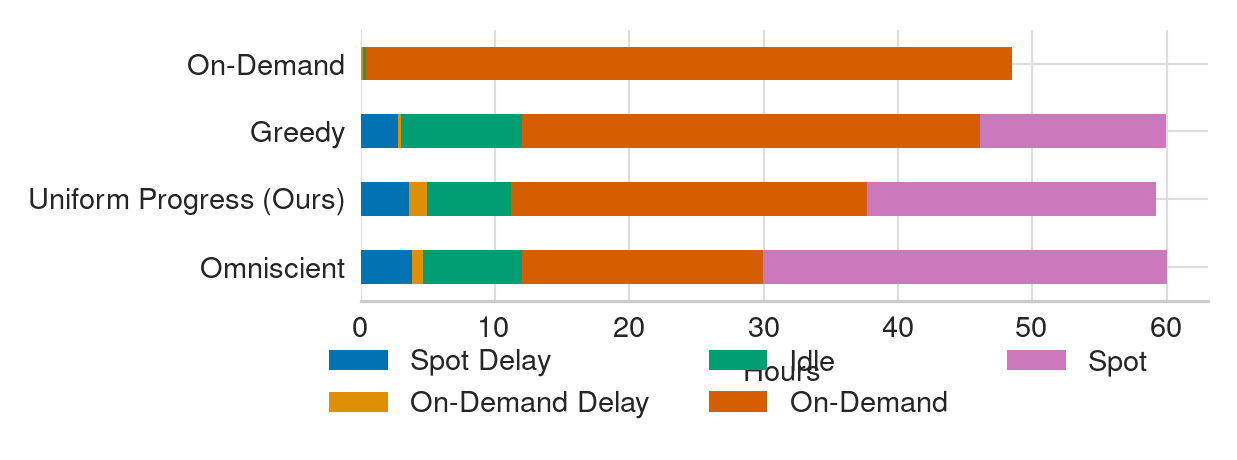

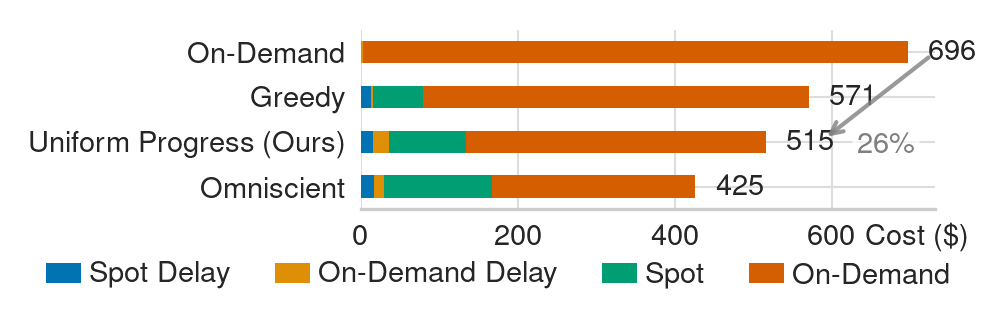

In [15]:
from sky_spot.utils import ACTUAL_COSTS
def add_total_annotations(ax, df):
    for i, strategy in enumerate(df.index):
        total_value = df.loc[strategy].sum()
        ax.annotate(f'{total_value:.0f}',
                    xy=(total_value, i),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center')

def add_arrow_and_percentage(ax, df, bar1_index, bar2_index):
    bar1_total = df.iloc[bar1_index].sum()
    bar2_total = df.iloc[bar2_index].sum()
    percentage_diff = (bar1_total - bar2_total) / bar1_total * 100

    arrow_shift = bar1_total / 10
    arrow_start_x = bar1_total + arrow_shift * 0.5
    arrow_start_y = bar1_index
    arrow_end_x = bar2_total + arrow_shift
    arrow_end_y = bar2_index

    ax.annotate("",
                xy=(arrow_end_x, arrow_end_y),
                xytext=(arrow_start_x, arrow_start_y),
                arrowprops=dict(arrowstyle="->", lw=1, color='gray', alpha=0.8),
                annotation_clip=False)

    label_x = (arrow_start_x + arrow_end_x) / 2
    label_y = (arrow_start_y + arrow_end_y) / 2
    ax.annotate(f'{percentage_diff:.0f}\%',
                xy=(label_x, label_y),
                xytext=(-5, -15),
                textcoords='offset points',
                ha='left',
                va='bottom',
                color='gray',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='white', boxstyle='round,pad=0.1'))



color = sns.color_palette('colorblind')
palette = [color[0], color[1], color[2], color[3], color[4]]
# color = sns.color_palette('pastel')
# fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .3))
fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - .8))
ax = fig.add_subplot(111)
axes = [ax, ax]
# axes = fig.subplots(2, 1, sharey=True)
strategies = ['On-Demand', 'Greedy', f'{OUR_NAME} (plain)', f'{OUR_NAME} (Ours)', 'Omniscient']
strategies = ['On-Demand', 'Greedy', f'{OUR_NAME} (Ours)', 'Omniscient']
df = pd.DataFrame()
df['Spot Delay'] = aggregated['switch_to_spot'] * OVERHEAD
df['On-Demand Delay'] = aggregated['switch_to_vm'] * OVERHEAD
df['Idle'] = aggregated['idle_time'] * gap_seconds / 3600
df['On-Demand'] = aggregated['vm_time'] * gap_seconds / 3600 - df['On-Demand Delay']
df['Spot'] = aggregated['spot_time'] * gap_seconds / 3600 - df['Spot Delay']

df.reset_index(inplace=True)
df.loc[df['strategy'] == f'{OUR_NAME}', 'strategy'] = f'{OUR_NAME} (Ours)'

df = df[df['strategy'].isin(strategies)]
# df.loc[df['strategy'] == 'spot', 'spot_hours'] = df.loc[df['strategy'] == 'spot', 'spot_hours'] + df.loc[df['strategy'] == 'spot', 'spot_overhead']
# df.loc[df['strategy'] == 'spot', 'spot_overhead'] = 0
df['strategy'] = pd.Categorical(df['strategy'], strategies)
df.sort_values('strategy', inplace=True, ascending=False)
df.set_index('strategy').plot(kind='barh',
                              stacked=True,
                              xlabel='Hours',
                              ylabel='Strategy',
                              title=f'Time Breakdown',
                              ax=axes[0],
                              edgecolor='white',
                              linewidth=0,
                              color=color)
# add_total_annotations(axes[0], df.set_index('strategy'))
axes[0].legend().set_visible(False)
axes[0].set_title('')
axes[0].set_ylabel('')
handler_ax = axes[0]
fig.legend(title='',
           loc='lower center',
           ncol=3,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.18))
if DATE == '':
    fig.savefig(f'figures/time_breakdown.pdf', bbox_inches='tight')

# fig.suptitle(f'Strategy Breakdown on {env_name} (d={OVERHEAD:.1f}h)')
fig.tight_layout()

fig = plt.figure(dpi=300, figsize=(fig_width, fig_height - 1.1))
ax = fig.add_subplot(111)
axes = [ax, ax]

from sky_spot.utils import ClusterType, COSTS

spot_price = COSTS[ClusterType.SPOT] * cost_scale
vm_price = COSTS[ClusterType.ON_DEMAND] * cost_scale
if DATE != '':
    for device in ACTUAL_COSTS:
        if device in env_name:
            vm_price = ACTUAL_COSTS[device][0]
            spot_price = ACTUAL_COSTS[device][1]
            break
    else:
        raise


cost_df = pd.DataFrame()
cost_df['strategy'] = df['strategy']
cost_df['Spot Delay'] = df['Spot Delay'] * spot_price
cost_df['On-Demand Delay'] = df['On-Demand Delay'] * vm_price
cost_df['Spot'] = df['Spot'] * spot_price
cost_df['On-Demand'] = df['On-Demand'] * vm_price
# cost_df['Idle'] = 0

cost_df.reset_index(inplace=True)
cost_df['strategy'] = pd.Categorical(cost_df['strategy'], strategies)
cost_df.sort_values('strategy', inplace=True, ascending=False)
cost_df.drop(columns=['index'], inplace=True)
cost_df.set_index('strategy').plot(kind='barh', stacked=True, xlabel='Cost', ylabel='Strategy', title=f'Cost Breakdown', ax=axes[1], edgecolor='white', linewidth=0, color=color)
add_total_annotations(axes[1], cost_df.set_index('strategy'))
add_arrow_and_percentage(axes[1], cost_df.set_index('strategy'), 3, 1)

axes[1].set_title('')
axes[1].set_ylabel('')
label = axes[1].set_xlabel(r'Cost (\$)',
                           ha='right',
                           position=(1, 0),
                           bbox=dict(facecolor='white',
                                     alpha=1,
                                     edgecolor='none',
                                     boxstyle='round,pad=0.1'))
axes[1].xaxis.set_label_coords(1.06, -0.28)
x, y = label.get_position()
label.set_position((x, y + 0.2))
for ax in axes:
    ax.legend().set_visible(False)

handler_ax = axes[0]
fig.legend(title='',
           loc='lower center',
           ncol=4,
           columnspacing=1.5,
           handlelength=1.2,
           handletextpad=0.3,
           handles=handler_ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, -0.1))

# fig.suptitle(f'Strategy Breakdown on {env_name} (d={OVERHEAD:.1f}h)')
fig.tight_layout()
if DATE == '2023-04-22-29':
    fig.savefig(f'figures/ml_breakdown.pdf', bbox_inches='tight', pad_inches=0)
elif DATE == '2023-04-19-29':
    fig.savefig(f'figures/spark_breakdown.pdf', bbox_inches='tight')
else:
    fig.savefig(f'figures/time_cost_breakdown.pdf', bbox_inches='tight')

In [16]:
## Load all env names

                   strategy  switch_to_spot  switch_to_vm
0                    Greedy       13.983333      1.000000
1                Omniscient       19.196667      4.136667
2                 On-Demand        0.000000      1.000000
3          Uniform Progress       17.903333      6.713333
4  Uniform Progress (plain)       22.796667     17.626667
5                 only spot       29.296667      0.000000


NameError: name 'NUM_SLICES' is not defined

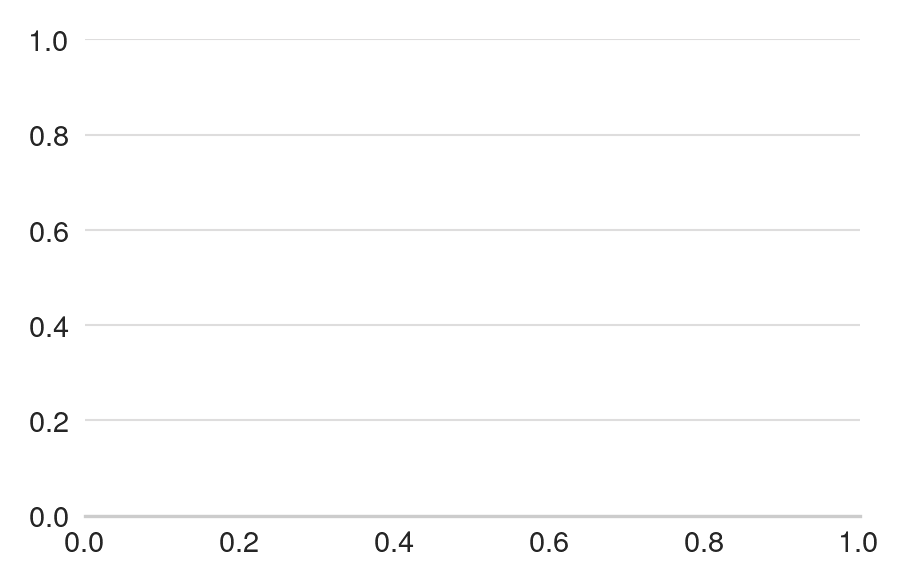

In [17]:
fig = plt.figure(dpi=300)
ax = fig.subplots(1, 1)
switch_df = pd.DataFrame(columns=['switch_to_spot', 'switch_to_vm'])
switch_df['switch_to_spot'] = aggregated['switch_to_spot']
switch_df['switch_to_vm'] = aggregated['switch_to_vm']
switch_df.reset_index(inplace=True)
print(switch_df)
switch_df['strategy'] = pd.Categorical(switch_df['strategy'], [
    'only spot', 'greedy', f'sliced ({NUM_SLICES})',
    f'{OUR_NAME}', f'{OUR_NAME} (V2DT)', 'Omniscient'
])
switch_df.sort_values('strategy', inplace=True, ascending=False)
switch_df.set_index('strategy').plot(kind='barh', stacked=True, xlabel='Switches', ylabel='Strategy', title=f'Strategy Switch Breakdown on {env_name}\n(d={OVERHEAD:.1f}h)', ax=ax)


KeyError: 'vm'

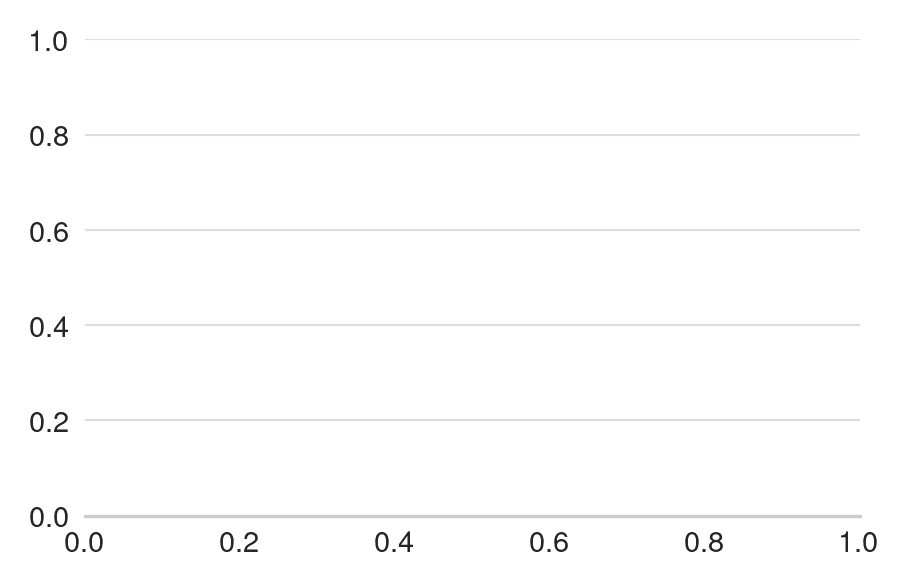

In [ ]:
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots(1, 1)
effective_price_df = pd.DataFrame(columns=['strategy', 'vm', 'spot'])
effective_price_df['strategy'] = df['strategy']
effective_price_df['vm'] = vm_price * (
    df['vm'] + df['vm_overhead']) / df['vm'] if df['vm'].sum() > 0 else 0
effective_price_df['spot'] = spot_price * (df['spot'] +
                                           df['spot_overhead']) / df['spot']
effective_price_df.reset_index(inplace=True)
effective_price_df['strategy'] = pd.Categorical(
    effective_price_df['strategy'], [
        'only spot', 'Greedy', f'{OUR_NAME} (plain)',
        f'{OUR_NAME}', 'Omniscient'
    ])
effective_price_df = pd.concat([
    effective_price_df,
    pd.DataFrame({
        'strategy': ['price'],
        'vm': [vm_price],
        'spot': [spot_price],
    })
])
print(effective_price_df)
effective_price_df['strategy'] = pd.Categorical(
    effective_price_df['strategy'], [
        'only spot', 'Greedy', f'{OUR_NAME} (plain)', f'{OUR_NAME}',
        'Omniscient'
    ])
effective_price_df.sort_values('strategy', inplace=True, ascending=True)
effective_price_df.drop(columns=['index'], inplace=True)
effective_price_df.set_index('strategy').plot(
    kind='bar',
    xlabel='Strategy',
    ylabel='Effective price',
    title=f'Effective Price on {env_name} (d={OVERHEAD:.1f}h)',
    ax=ax,
    color=[colors[0], colors[2]])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_xlabel('')
# ax.hlines(xmin=0, xmax=5, y=effective_price_df['vm'].values[0], color='r', linestyle='--', label=f'{OUR_NAME} (V2DT)')

ax.legend(loc='upper left')

fig.tight_layout()
# fig.savefig(f'figures/effective_price.pdf', bbox_inches='tight')


/tmp/ipykernel_27988/2216840283.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['strategy'] = pd.Categorical(
/tmp/ipykernel_27988/2216840283.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.sort_values('strategy', inplace=True, ascending=True)


     strategy   vm spot
2  Omniscient  NaN  NaN
2    NaN
Name: vm, dtype: object


ValueError: Axis limits cannot be NaN or Inf

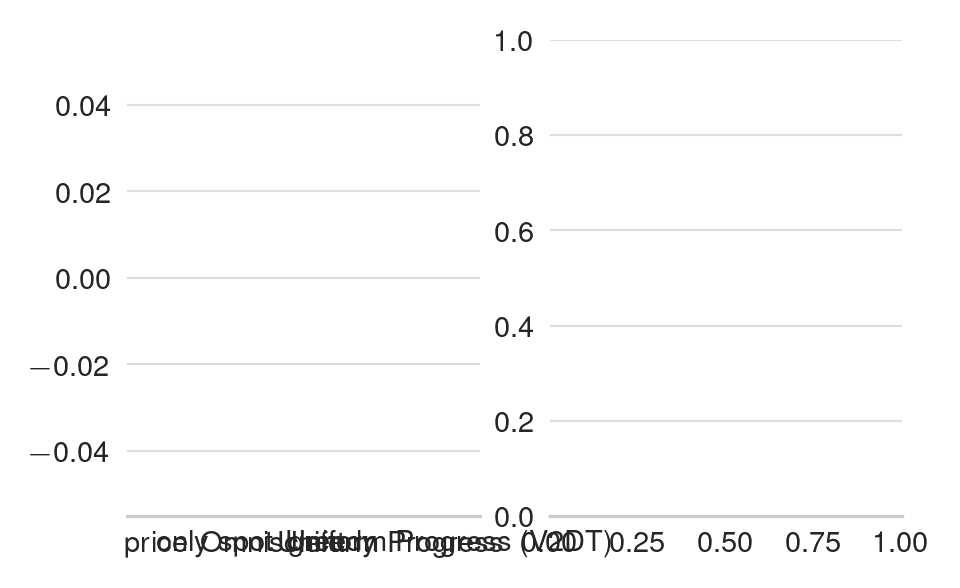

In [ ]:
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
axes = fig.subplots(1, 2,)

strategies = [
    'price',
    'only spot',
    'Omniscient',
    'greedy',
    # f'sliced ({NUM_SLICES})',
    f'{OUR_NAME}',
    f'{OUR_NAME} (V2DT)',
]
plot_df = effective_price_df[effective_price_df['strategy'].isin(strategies)]
plot_df['strategy'] = pd.Categorical(
    plot_df['strategy'], strategies)
plot_df.sort_values('strategy', inplace=True, ascending=True)
print(plot_df)
for i, name in enumerate(['vm', 'spot']):
    ax = axes[i]
    print(plot_df[name])
    sns.barplot(x=plot_df['strategy'], y=plot_df[name], ax=ax, color=colors[i*2])
    ax.set_xlabel('')
    ax.set_ylabel('')
    y_min = 0.95 * plot_df[name].min()
    if name == 'vm':
        y_max = 1.06 * plot_df[name].max()
    else:
        y_max = 1.06 * plot_df[name].max()
        # ax.set_yticks([7.75, 8.25, 8.75])
    ax.set_ylim(y_min, y_max)
    ax.set_xticklabels(plot_df['strategy'], rotation=30, ha='right')
axes[0].set_title('VM Effective Price')
axes[1].set_title('Spot Effective Price')
axes[0].set_ylabel(r'Effective price (\$)')

fig.suptitle(f'Effective Price on {env_name}\n(d={OVERHEAD:.1f}h, Task={TASK_DURATION_HOURS}, Deadline={DDL})')
fig.tight_layout(pad=.5)
fig.savefig(f'figures/effective_price.pdf', bbox_inches='tight')